In [4]:
import os
import glob
import random
import re
import pickle
import gc

import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKeras

import tqdm

import cv2

import tensorflow as tf

from tensorflow.keras import layers, models, callbacks
from tensorflow.image import resize_with_pad

from tensorflow.keras.preprocessing.image import (
    load_img, 
    img_to_array, 
    ImageDataGenerator,
    array_to_img,
    save_img
)

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

## Image preprocessing

The approach is simiilar to image processing and bsic EDA for non-DL models, refer to Non-DL notebook for image size analysis, etc

In [32]:
DIR_PATH = os.path.abspath('C:/temp_workfolder/rbc_mvp')
folders = os.listdir(DIR_PATH)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:\\temp_workfolder\\rbc_mvp'

In [5]:
TARGET_HEIGHT = 128
TARGET_WIDTH = 128

In [3]:
def preprocess_img_to_arr(img, target_height = TARGET_HEIGHT, target_width = TARGET_WIDTH):
    img_arr = np.asarray(img)
    img_tensor = tf.convert_to_tensor(img_arr)

    new_img_arr = resize_with_pad(
        img_tensor, 
        target_height, 
        target_width, 
        method = 'nearest',
        antialias = True
    )
    
    return new_img_arr

In [ ]:
# store preprocessed images in new folder
NEW_DIR_PATH = os.path.abspath('C:/temp_workfolder/rbc_mvp/preproc')

In [119]:
if os.path.exists(NEW_DIR_PATH) == False:     #creates a folder if it doesn't exist
        os.mkdir(NEW_DIR_PATH)
    
for folder in folders:
    folder_path = os.path.join(DIR_PATH, folder)
    new_folder_path = os.path.join(NEW_DIR_PATH, folder)
    if os.path.exists(new_folder_path) == False:     #creates a folder if it doesn't exist
        os.mkdir(new_folder_path)
    
    imgs = os.listdir(folder_path)
    
    for img in imgs:
        img_path = os.path.join(folder_path, img)
        new_img_path = os.path.join(new_folder_path, img)
        
        img = load_img(img_path)
        img_arr = preprocess_img_to_arr(img)
        save_img(new_img_path, img_arr)

=====================================================

### Below is train/test/val splitting the images into according folders

In [8]:
NEW_DIR_PATH2 = os.path.abspath('C:/temp_workfolder/rbc_keras/')

In [9]:
#https://stackoverflow.com/questions/57394135/split-image-dataset-into-train-test-datasets

import splitfolders # or import splitfolders
input_folder = NEW_DIR_PATH2
output = os.path.join(NEW_DIR_PATH2, "keras_split") #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.6, .2, .2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 7108 files [02:55, 40.50 files/s]


### Use the train-test-split image sets

In [4]:
split_dir = 'C:/temp_workfolder/rbc_keras/keras_split' 
os.listdir(split_dir)

['test', 'train', 'val']

In [5]:
preproc_dir = "C:/temp_workfolder/rbc_keras/keras_split"
os.listdir(preproc_dir)

['test', 'train', 'val']

# ===================

## 0. Augemnting and creating image data
### For NN modelling I will use the train-val-test set obtained from splitfolders 

In [6]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
)

Parameters tuned for NN modeling are image size and batch sizes

In [7]:
#batch_size = 256

train_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/train',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 768,
    class_mode = 'categorical',
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

val_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/val',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 1021,
    class_mode = 'categorical',
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

test_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/test',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 1021,
    class_mode = 'categorical',   #'categorical'
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

Found 4261 images belonging to 9 classes.
Found 1418 images belonging to 9 classes.
Found 1429 images belonging to 9 classes.


In [6]:
train_gen.class_indices

{'acantocyte': 0,
 'elliptocyte': 1,
 'hypochromic': 2,
 'normal': 3,
 'pencil': 4,
 'spero_bulat': 5,
 'stomatocyte': 6,
 'targetsel': 7,
 'teardrop': 8}

In [7]:
#train_gen.filenames[1000:1010]

In [8]:
X_train, Y_train = next(train_gen)
print(X_train.shape)
print(Y_train.shape)

(768, 128, 128, 3)
(768, 9)


In [9]:
X_val, Y_val = next(val_gen)
print(X_val.shape)
print(Y_val.shape)

(1021, 128, 128, 3)
(1021, 9)


In [10]:
X_test, Y_test = next(test_gen)
print(X_test.shape)
print(Y_test.shape)

(1021, 128, 128, 3)
(1021, 9)


## 1. Building a custom CNN model
- Parametes such as filter and dense layer dimensions, numbers of layers were tuned. Main goal was to:<br>
-  - Achieve a better model score while minimize overfitting

- Only a few showcases of trials were included here


In [9]:
# Custom

model_test = Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(TARGET_HEIGHT,TARGET_WIDTH,3), padding="same"),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="same"),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="same"),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),

    #64
    #128
    #128
    
    layers.Flatten(),
    layers.Dense(768, activation='relu'),   #1024
    layers.Dropout(0.9),
    layers.Dense(256, activation='relu'),    #1024
    layers.Dropout(0.9),
    #layers.Dense(768, activation='relu'),
    #layers.Dropout(0.6),

    #layers.Dense(64, activation='relu'),
    #layers.Dropout(0.8),
    layers.Dense(9, activation='softmax')
])
tf.keras.backend.clear_session() 
gc.collect()


345

In [12]:
gc.collect()


0

In [13]:
model_test.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

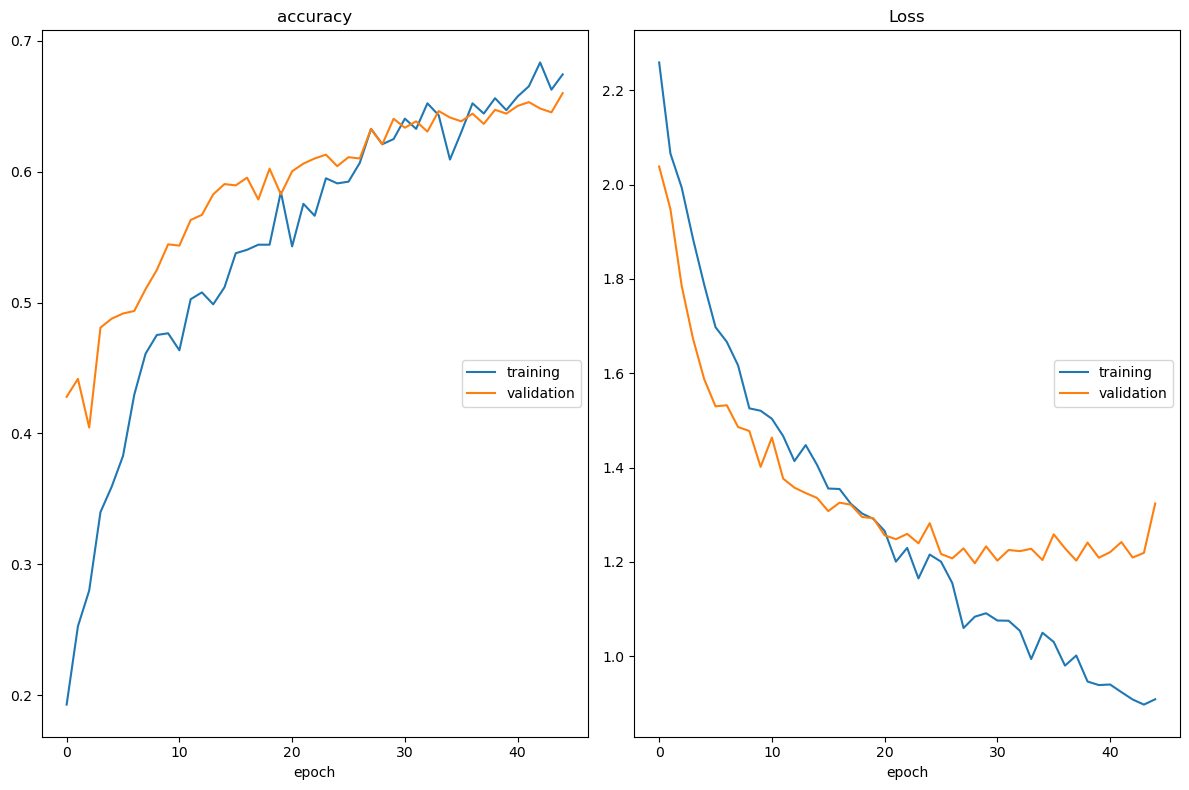

accuracy
	training         	 (min:    0.193, max:    0.684, cur:    0.674)
	validation       	 (min:    0.405, max:    0.660, cur:    0.660)
Loss
	training         	 (min:    0.897, max:    2.259, cur:    0.908)
	validation       	 (min:    1.197, max:    2.038, cur:    1.324)
24/24 [==============================] - 1s 38ms/step - loss: 0.9084 - accuracy: 0.6745 - val_loss: 1.3236 - val_accuracy: 0.6601


67971

In [16]:
# batch size 512
# img size 128
# dropout 0.87

model_test.fit(X_train,
               Y_train,
               epochs=100,
               #steps_per_epoch=32,
               validation_data=(X_val,Y_val),
               validation_freq=1,
               callbacks=[EarlyStopping(patience=16, verbose=0),PlotLossesKeras()]
              )
gc.collect()

### Below are some of the attempts I made on custon NN model

Transfer learning with Alexnet

In [23]:
model_alex = models.Sequential([
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])
tf.keras.backend.clear_session() 
gc.collect()

668

In [24]:
# Transfer 0

model_test0 = Sequential()
model_test0.add(model_alex)
model_test0.add(Flatten())
model_test0.add(Dense(768, activation='relu'))
model_test0.add(layers.Dropout(0.5))
model_test0.add(Dense(256, activation='relu'))
model_test0.add(layers.Dropout(0.5))
model_test0.add(Dense(9, activation='softmax'))



tf.keras.backend.clear_session() 
gc.collect()


2760

In [25]:
model_test0.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_test0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 9)                 23441801  
                                                                 
 flatten (Flatten)           (None, 9)                 0         
                                                                 
 dense (Dense)               (None, 768)               7680      
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               196864    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 9)                 2

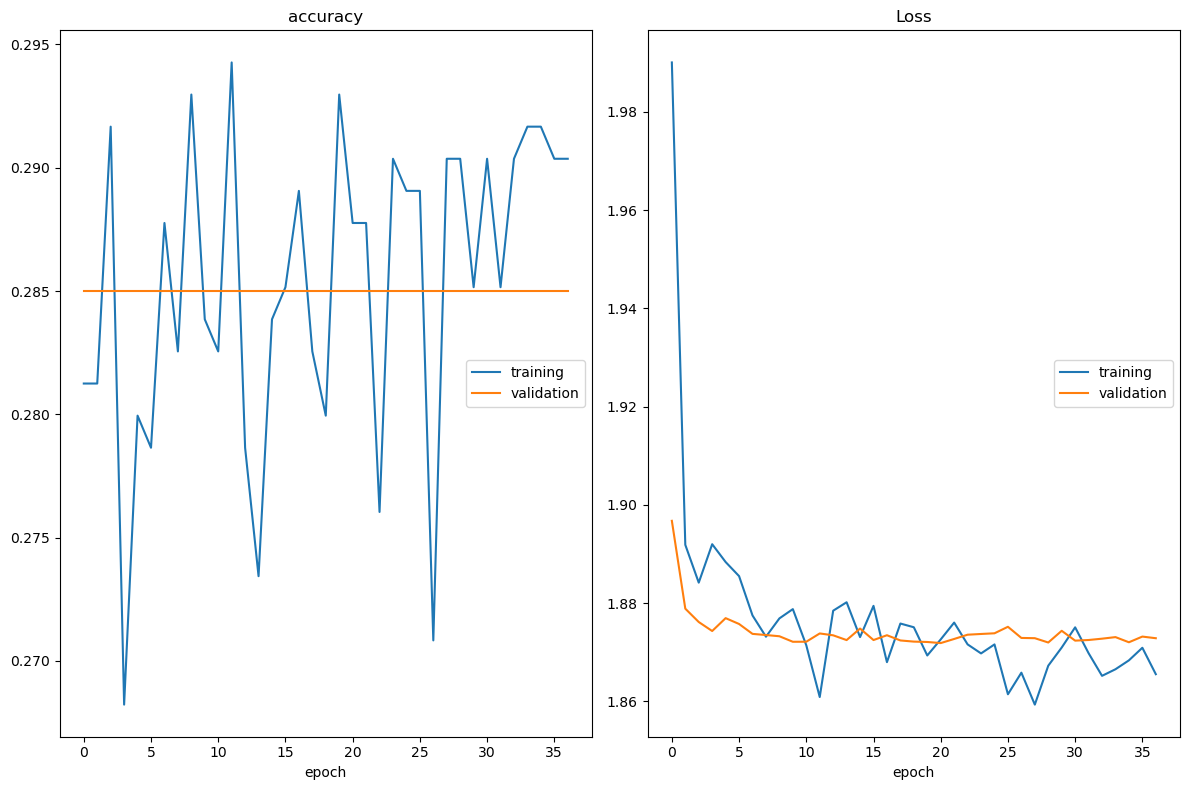

accuracy
	training         	 (min:    0.268, max:    0.294, cur:    0.290)
	validation       	 (min:    0.285, max:    0.285, cur:    0.285)
Loss
	training         	 (min:    1.859, max:    1.990, cur:    1.866)
	validation       	 (min:    1.872, max:    1.897, cur:    1.873)
24/24 [==============================] - 1s 46ms/step - loss: 1.8656 - accuracy: 0.2904 - val_loss: 1.8729 - val_accuracy: 0.2850


141836

In [26]:
model_test0.fit(X_train,
               Y_train,
               epochs=100,
               #steps_per_epoch=32,
               validation_data=(X_val,Y_val),
               #validation_freq=1,
               callbacks=[EarlyStopping(patience=16, verbose=0),PlotLossesKeras()]
              )
gc.collect()

Transfer learning with resnet

In [11]:
resnet_model = ResNet50(weights=None, classes=9, include_top=False, input_shape=(128, 128, 3))
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
print(resnet_model.summary())
gc.collect()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

817

In [12]:
gc.collect()

0

In [13]:
# Transfer1

model_test1 = Sequential()
model_test1.add(resnet_model)
model_test1.add(Flatten())
model_test1.add(Dense(128, activation='relu'))
model_test1.add(layers.Dropout(0.5))
model_test1.add(Dense(256, activation='relu'))
model_test1.add(layers.Dropout(0.5))
model_test1.add(Dense(9, activation='softmax'))

tf.keras.backend.clear_session() 
gc.collect()

8515

In [15]:
model_test1.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_test1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 9)                 2

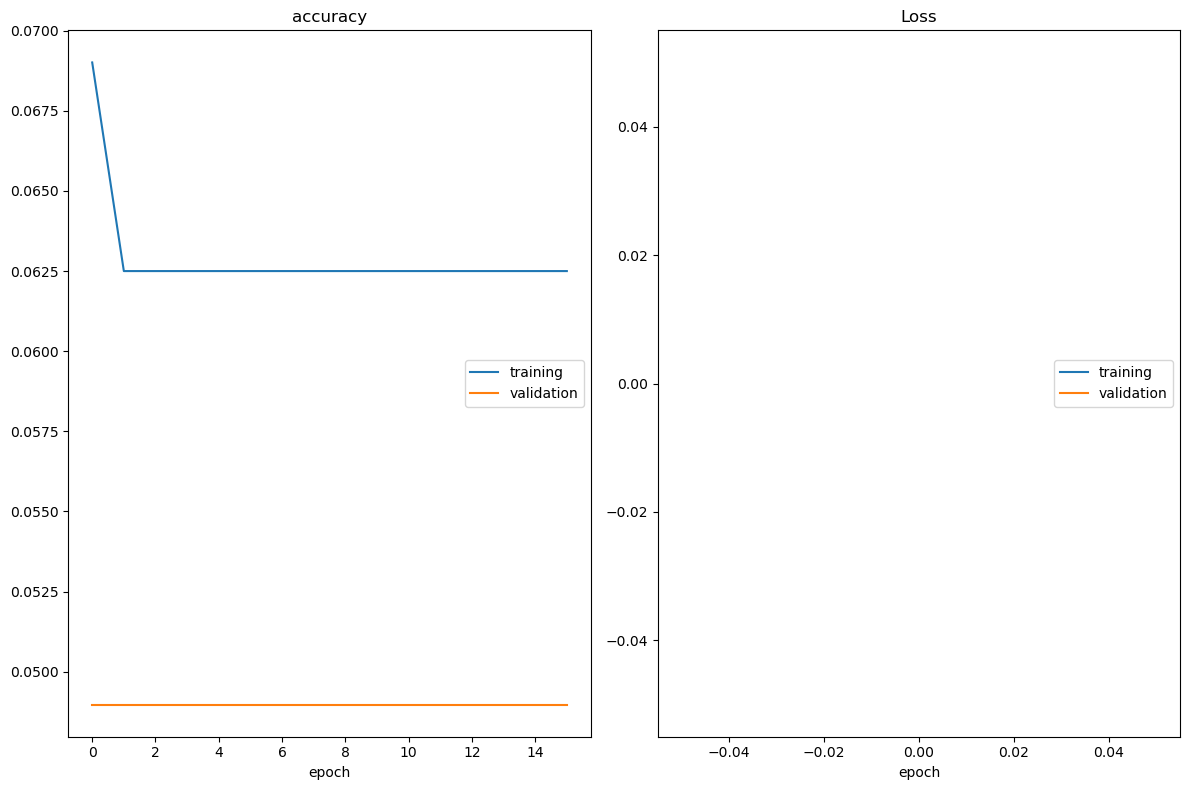

accuracy
	training         	 (min:    0.062, max:    0.069, cur:    0.062)
	validation       	 (min:    0.049, max:    0.049, cur:    0.049)
Loss
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:      nan, max:      nan, cur:      nan)
24/24 [==============================] - 3s 147ms/step - loss: nan - accuracy: 0.0625 - val_loss: nan - val_accuracy: 0.0490


61209

In [16]:
model_test1.fit(X_train,
               Y_train,
               epochs=40,
               #steps_per_epoch=32,
               validation_data=(X_val,Y_val),
               validation_freq=1,
               callbacks=[EarlyStopping(patience=16, verbose=0),PlotLossesKeras()]
              )
gc.collect()

In [41]:
gc.collect()

0

In [81]:
# batch size 512

model_test.fit(
          X_train,
          Y_train,
          epochs=100,
          validation_data=(X_val,Y_val),
          validation_freq=1,
          )

Epoch 1/100
16/16 [==============================] - 1s 47ms/step - loss: 2.3662 - accuracy: 0.1914 - val_loss: 2.1377 - val_accuracy: 0.3008
Epoch 2/100
16/16 [==============================] - 0s 22ms/step - loss: 2.0340 - accuracy: 0.2480 - val_loss: 2.0451 - val_accuracy: 0.3008
Epoch 3/100
16/16 [==============================] - 0s 23ms/step - loss: 1.9566 - accuracy: 0.2598 - val_loss: 1.9999 - val_accuracy: 0.3008
Epoch 4/100
16/16 [==============================] - 0s 22ms/step - loss: 1.9237 - accuracy: 0.2656 - val_loss: 1.9517 - val_accuracy: 0.3008
Epoch 5/100
16/16 [==============================] - 0s 22ms/step - loss: 1.8344 - accuracy: 0.2617 - val_loss: 1.8354 - val_accuracy: 0.3008
Epoch 6/100
16/16 [==============================] - 0s 24ms/step - loss: 1.7904 - accuracy: 0.2617 - val_loss: 1.8023 - val_accuracy: 0.3008
Epoch 7/100
16/16 [==============================] - 0s 24ms/step - loss: 1.7308 - accuracy: 0.2891 - val_loss: 1.7267 - val_accuracy: 0.3008
Epoch 

In [11]:
result = model_test.fit(
    X_train, 
    Y_train,
    #steps_per_epoch=16,
    epochs=100,
    validation_data=(X_val,Y_val),
    callbacks=[EarlyStopping(patience=16, verbose=1)]
)

Epoch 1/100
8/8 [==============================] - 4s 62ms/step - loss: 2.4591 - accuracy: 0.1602 - val_loss: 2.1568 - val_accuracy: 0.2930
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 2.1402 - accuracy: 0.1914 - val_loss: 2.0647 - val_accuracy: 0.2930
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 2.1201 - accuracy: 0.2188 - val_loss: 2.0769 - val_accuracy: 0.2930
Epoch 4/100
8/8 [==============================] - 0s 37ms/step - loss: 2.0739 - accuracy: 0.2539 - val_loss: 2.0160 - val_accuracy: 0.2930
Epoch 5/100
8/8 [==============================] - 0s 37ms/step - loss: 2.0341 - accuracy: 0.2539 - val_loss: 2.0257 - val_accuracy: 0.2930
Epoch 6/100
8/8 [==============================] - 0s 36ms/step - loss: 2.0164 - accuracy: 0.2461 - val_loss: 1.9201 - val_accuracy: 0.2930
Epoch 7/100
8/8 [==============================] - 0s 39ms/step - loss: 2.0162 - accuracy: 0.2188 - val_loss: 1.9641 - val_accuracy: 0.2930
Epoch 8/100
8/8 [===

## 2. Applying custom NN into test dataset

In [19]:
model_test.predict(X_test)

array([[1.20489351e-01, 2.09135652e-01, 5.29081002e-02, ...,
        9.92169529e-02, 1.94415137e-01, 7.52257695e-03],
       [2.75250263e-18, 1.41778727e-07, 1.29568465e-18, ...,
        1.27539513e-14, 3.70189132e-18, 9.99999881e-01],
       [4.02610637e-02, 1.58050023e-02, 3.53435092e-02, ...,
        7.19008744e-02, 2.16900289e-01, 1.52393791e-03],
       ...,
       [1.64866503e-02, 8.15270096e-03, 2.00507659e-02, ...,
        4.10622768e-02, 2.75224060e-01, 2.77724845e-04],
       [1.45564318e-01, 2.33825177e-01, 5.37007190e-02, ...,
        1.28175080e-01, 1.09135285e-01, 3.24563570e-02],
       [4.23884541e-02, 2.16751900e-02, 3.94028015e-02, ...,
        7.12695047e-02, 2.83626229e-01, 1.44747726e-03]], dtype=float32)

In [30]:
# Assigns the most likely class for each image

y_pred = np.argmax(model_test.predict(X_test), axis=-1)
y_pred[:]

array([3, 8, 3, ..., 3, 1, 3], dtype=int64)

In [48]:
# The same procedure for the 'actual' data

Y_test_multilabel = np.argmax(Y_test, axis=-1)

In [47]:
label_to_name_dict = {label: name for name, label in test_gen.class_indices.items()}


In [49]:
#model_confusion_matrix = multilabel_confusion_matrix(Y_test_multilabel, y_pred)
model_confusion_matrix = confusion_matrix(Y_test_multilabel, y_pred)

In [50]:
model_confusion_matrix

array([[  7,  24,   0,  20,   0,   1,   0,   0,   0],
       [  0, 156,   0,   7,   0,   0,   0,   0,  18],
       [  0,   3,   0,  31,   0,   1,   0,   0,   1],
       [  0,   1,   0, 198,   0,   5,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3],
       [  0,   0,   0,  44,   0,  37,   0,   1,   0],
       [  0,   7,   0,  36,   0,   6,   0,   0,   0],
       [  0,   7,   0, 101,   0,   7,   0,  10,   0],
       [  1,  12,   0,   0,   0,   0,   0,   0, 274]], dtype=int64)

Text(95.58159722222221, 0.5, 'Actual')

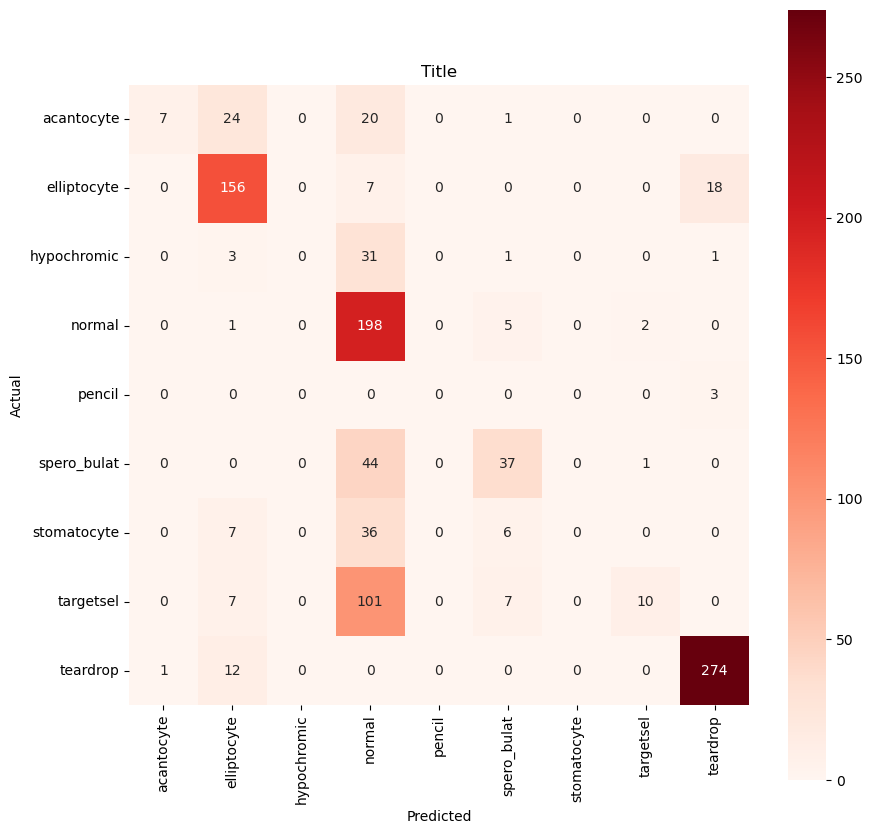

In [51]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(model_confusion_matrix, cmap='Reds', annot=True, square=True, fmt='d',
            xticklabels = list(label_to_name_dict.values()),
            yticklabels = list(label_to_name_dict.values()))
plt.title("Title")    
plt.xlabel('Predicted')
plt.ylabel('Actual')

The result is due to rather low accuracy of my custom NN model. However, increasing the model acuracy up to 0.7 and higher started to overfit severely. So I chose lower accuracy, minimal overfitting